# Détection de zones brûlées sur images satellites
Objectif : Développer un modèle de détection d’objets capable d’identifier et de localiser les zones brûlées sur des images satellites pour permettre une détection et un suivi des incendies, faire de la prévention, etc.
Entrée : images satellites 
Sortie attendue : rectangles englobants les zones brûlées sur l’image
→ Tâche de vision par ordinateur : détection d’objets


In [61]:
# Import
import json
from pathlib import Path

## Dataset - lecture
On dispose d’un jeu de données (zip en ressource du brief) comprenant : 
des photos satellite
les annotations correspondantes dans le fichier _annotations.coco.json 
source du dataset

- Regarder la doc et ouvrir le fichier : quelles sont les informations fournies ? 
→ Adapter l’affichage json dans VSCode pour Windows : Shift + Alt + F, pour Mac : Shift + Option + F

- Ajouter une fonction dans un fichier data_loader.py pour lire le fichier en utilisant json.load. 

- Ajouter une fonction qui charge les données dans des dataframes 


In [62]:
import json
from pathlib import Path

def load_json(file_path: str | Path) -> dict:
    """
    Lit un fichier JSON et retourne son contenu sous forme de dictionnaire.

    Args:
        file_path (str | Path): Chemin vers le fichier JSON.

    Returns:
        dict: Contenu du fichier JSON.

    Raises:
        FileNotFoundError: Si le fichier n’existe pas.
        json.JSONDecodeError: Si le contenu n'est pas un JSON valide.
    """
    file_path = Path(file_path)

    if not file_path.exists():
        raise FileNotFoundError(f"Le fichier {file_path} n’existe pas.")

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        raise ValueError(f"Le fichier {file_path} n'est pas un JSON valide : {e}")

    return data



file_path = Path("/home/nabil_simplon/wildfire-detection/data/satellite_wildfire_detection/satellite wildfire detection/_annotations.coco.json")
data = load_json(file_path)

# Vérification du fichier chargé
print(type(data))  # devrait afficher <class 'dict'>
print(data.keys()) # montre les clés principales du JSON
print(data)


<class 'dict'>
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
{'info': {'year': '2025', 'version': '2', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2025-09-14T12:06:19+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'wildfire', 'supercategory': 'none'}, {'id': 1, 'name': 'fire', 'supercategory': 'wildfire'}], 'images': [{'id': 0, 'license': 1, 'file_name': 'cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf.479904c9e54c6ba121689341598bf3ed.jpg', 'height': 860, 'width': 1200, 'date_captured': '2025-09-14T12:06:19+00:00', 'extra': {'name': 'cl6e1qges001kgk555z158f33_2_FALSE_COLOR.jpg'}}, {'id': 1, 'license': 1, 'file_name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf.95debd80b7509cc0a6afe0a7c7ff6cfe.jpg', 'height': 860, 'width': 1200, 'date_captured': '2025-09-14T12:06:1

In [63]:
import pandas as pd
import json
from typing import Union

def load_json_as_dataframe(data: Union[dict, list]) -> pd.DataFrame:
    """
    Convertit un objet JSON (dict ou list de dicts) en DataFrame pandas.

    Args:
        data (dict ou list): Données JSON déjà chargées.

    Returns:
        pd.DataFrame: Contenu du JSON sous forme de DataFrame.

    Raises:
        ValueError: Si le contenu JSON n'est pas compatible avec DataFrame.
    """
    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        raise ValueError("Le contenu JSON n'est pas un format compatible avec DataFrame")

    return df


In [64]:
export_data_to_df = load_json_as_dataframe(data)
display(export_data_to_df)

,info,licenses,categories,images,annotations
0,"{'year': '2025', 'version': '2', 'description'...","[{'id': 1, 'url': 'https://creativecommons.org...","[{'id': 0, 'name': 'wildfire', 'supercategory'...","[{'id': 0, 'license': 1, 'file_name': 'cl6e1qg...","[{'id': 0, 'image_id': 1, 'category_id': 1, 'b..."


## Exploration & nettoyage des données 


### a. Explorer les données pour en extraire les informations suivantes : 

- Nombre total d’image
- Nombre total d’annotations
- Quelles sont les catégories ?
- Nombre d’image par catégories
- Des statistiques sur le nombre d’annotation par image
etc…

Ajouter au moins 4 petites fonctions d’exploration dans un fichier data_explorer.py

Le dataframe est sous forme imbriqué : on va donc créer un dataframe pour la colonne 'Images', 'Annotations', 'catégories' : 

In [65]:
# Création du dataframe 'Images'
df_images = pd.DataFrame(data['images'])
display(df_images)

nombres_images = len(df_images)
print(f"Nombres d'images : {nombres_images}")

,id,license,file_name,height,width,date_captured,extra
0,0,1,cl6e1qges001kgk555z158f33_2_FALSE_COLOR_jpg.rf...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6e1qges001kgk555z158f33_2_FALSE_CO...
1,1,1,cl6kgm9qr002yc455g5qs87kz_2_FALSE_COLOR_jpg.rf...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6kgm9qr002yc455g5qs87kz_2_FALSE_CO...
2,2,1,cl6odzs5e002oao55heuig0a6_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6odzs5e002oao55heuig0a6_1_TRUE_COL...
3,3,1,cl6b6pieh007rl455fwvb73gr_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b6pieh007rl455fwvb73gr_1_TRUE_COL...
4,4,1,cl6b5k38g003zl455bgtd1317_4_FALSE_COLOR__URBAN...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b5k38g003zl455bgtd1317_4_FALSE_CO...
...,...,...,...,...,...,...,...
495,495,1,cl6b5yjxa005nl45516k465kb_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b5yjxa005nl45516k465kb_1_TRUE_COL...
496,496,1,cl6opv5oo007xao553de9g7wd_2_FALSE_COLOR_jpg.rf...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6opv5oo007xao553de9g7wd_2_FALSE_CO...
497,497,1,cl6cteplg00hkl4551scr5fko_1_TRUE_COLOR_jpg.rf....,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6cteplg00hkl4551scr5fko_1_TRUE_COL...
498,498,1,cl6b652mi0068l4552keu9loj_6_SWIR_jpg.rf.113908...,860,1200,2025-09-14T12:06:19+00:00,{'name': 'cl6b652mi0068l4552keu9loj_6_SWIR.jpg'}


Nombres d'images : 500


In [66]:
# Création du dataframe 'annotations'
df_annotations = pd.DataFrame(data['annotations'])
display(df_annotations)

nombres_annotations = len(df_annotations)
print(f"Nombres d'annotations : {nombres_annotations}")

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,1,1,"[277, 207, 568.95, 591.79]",336698.921,[],0
1,1,2,1,"[800, 0, 157.45, 413.38]",65086.681,[],0
2,2,2,1,"[1062, 96, 58.37, 63.91]",3730.427,[],0
3,3,2,1,"[452, 442, 410.09, 350.6]",143777.554,[],0
4,4,2,1,"[0, 163, 336.16, 375.08]",126086.893,[],0
...,...,...,...,...,...,...,...
954,954,496,1,"[80, 30, 416.05, 183.75]",76449.188,[],0
955,955,496,1,"[0, 345, 140.33, 146.25]",20523.263,[],0
956,956,497,1,"[389, 361, 333, 340.52]",113393.160,[],0
957,957,498,1,"[510, 270, 222.6, 245.95]",54748.470,[],0


Nombres d'annotations : 959


In [ ]:
# Création du dataframe 'catégories'
df_categories = pd.DataFrame(data['categories'])
display(df_categories)

nombres_categories = len(df_categories)
print(f"Nombres de catégories : {nombres_categories}")


,id,name,supercategory
0,0,wildfire,none
1,1,fire,wildfire


Nombres de catégories : 2
2


La raison pour laquelle on fait un merge entre df_annotations et df_categories est liée à la structure des données COCO :

df_annotations contient :

- image_id → l’ID de l’image où se trouve l’annotation

- category_id → l’ID de la catégorie de l’objet annoté

- Mais il n’y a pas le nom réel de la catégorie, juste son ID (par exemple 0 ou 1).

df_categories contient :

- id → le même category_id que dans les annotations

- name → le nom humain de la catégorie (fire ou wildfire)

images (id)  ←→  annotations (image_id, category_id)  ←→  categories (id)


In [ ]:
# On merge df_annotations avec df_categories afin de pouvoir avoir le nombre d'image par category, car il n'y'a pas de foreign key entre images et categories:
# merge = combine les infos pour compter par nom au lieu de l'ID.

df_merged = df_annotations.merge(df_categories,left_on='category_id', right_on='id')

# Nombre d'images distinctes par catégorie
df_images_par_categories = df_merged.groupby("name")["image_id"].nunique()

display(df_images_par_categories)

name
fire    493
Name: image_id, dtype: int64

unique() :

Renvoie toutes les valeurs uniques d’une série ou d’une colonne sous forme de tableau/array.

nunique() :

Renvoie le nombre de valeurs uniques.

In [106]:
# Nombres d'annotations par images
df_merged_a_i = df_annotations.merge(df_images,left_on='image_id', right_on='id')

df_nombres_annotations_par_images = df_merged_a_i.groupby("file_name")["image_id"].count()

print(df_nombres_annotations_par_images)

file_name
cl6az56oy0003f05554mh92wy_2_FALSE_COLOR_jpg.rf.80849284d2ee075dcfd0d457f4c20b7a.jpg           1
cl6azgmfw0004f0557iqa1usw_6_SWIR_jpg.rf.0f5204c03b972113e76c964eada21109.jpg                  2
cl6azt6by0000go55h4io4tab_2_FALSE_COLOR_jpg.rf.7bd6bf61c42f8477a59d290789795964.jpg           2
cl6azt6by0000go55h4io4tab_6_SWIR_jpg.rf.f8a793559d8103b9c237ca96944514b5.jpg                  2
cl6azvz950000t0552g8v22is_1_TRUE_COLOR_jpg.rf.9324abe7caa6850140e03d5454f3abb4.jpg            1
                                                                                             ..
cl6ou8fz600abao5561sobj5z_1_TRUE_COLOR_jpg.rf.1ff7bea9ba4b1da2adb2975211554bc8.jpg            1
cl6oui3xy00aoao55d29e9vlz_4_FALSE_COLOR__URBAN_jpg.rf.75cb4ab2e4d84a20ae05d606f0cd9f7e.jpg    1
cl6ouiflj00apao55ef14ha2q_6_SWIR_jpg.rf.847b99640495bcb4aa215b63c1c3cde6.jpg                  1
cl6oujpxm00atao554qpycnsr_2_FALSE_COLOR_jpg.rf.80ca6bf8c90969f299e1fa5127fc8523.jpg           4
cl6oul0ve00axao5549vy6mom_4_FA

Moyenne : 1.95
Médiane : 1.0
Écart-type : 1.41
Minimum : 1
Maximum : 10


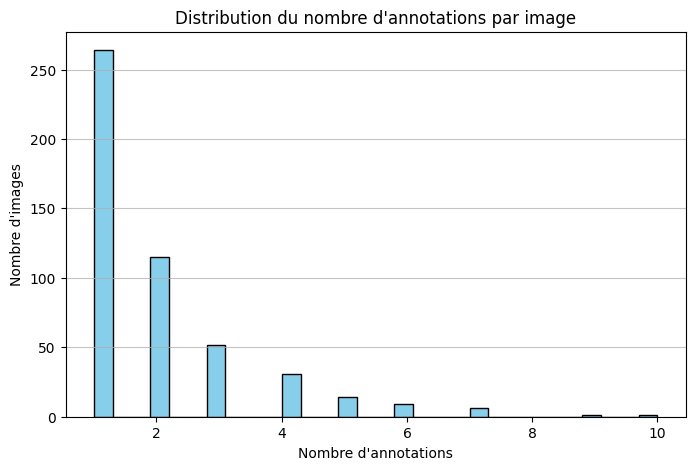

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que df_merged_a_i est la DataFrame fusion née du merge annotations/images
# Compter le nombre d'annotations par image (fichier)
annotations_per_image = df_merged_a_i.groupby("file_name")["image_id"].count()

# Calcul des statistiques principales
mean_val = annotations_per_image.mean()
median_val = annotations_per_image.median()
std_val = annotations_per_image.std()
min_val = annotations_per_image.min()
max_val = annotations_per_image.max()

# Afficher les statistiques
print(f"Moyenne : {mean_val:.2f}")
print(f"Médiane : {median_val}")
print(f"Écart-type : {std_val:.2f}")
print(f"Minimum : {min_val}")
print(f"Maximum : {max_val}")

# Visualiser la distribution avec un histogramme
plt.figure(figsize=(8,5))
annotations_per_image.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution du nombre d'annotations par image")
plt.xlabel("Nombre d'annotations")
plt.ylabel("Nombre d'images")
plt.grid(axis='y', alpha=0.75)
plt.show()


Ajouter au moins 4 petites fonctions d’exploration dans un fichier data_explorer.py

### b. Vérification des incohérences dans les données 

Dans un fichier data_cleaner.py :
- Ecrire une fonction qui renvoie les extensions des fichiers
Possibilité d’utiliser une boucle for ou compréhension de liste sur tous les fichiers d’un dossier avec os ou pathlib (cf 2 premiers exemples de cette page)
- Ecrire une fonction qui vérifie la cohérence entre les images disponibles et les images présentes dans _annotations.coco.json
- Ecrire une fonction qui renvoie la liste des images sans annotations s’il y en a
Piste de raisonnement
- Créer une liste d’id unique dans les annotations (pandas unique)
- Filtrer le dataframe d’images en ne gardant que les images telles que l’id ne soient pas dans la liste d’id unique (exemple pandas)
- Afficher pour vérifier leur contenu par exemple avec : 

from PIL import Image
img = Image.open(image_path)

- Écrire une fonction qui renvoie les annotations ne correspondant à aucune image
- Écrire une fonction qui détecte les valeurs aberrantes pour les annotations (ex : hauteur == 0 et largeur != 0, etc)


### c. Nettoyage

Dans le fichier data_cleaner.py :
- Choisir comment traiter ces anomalies du côté des images et du fichier .coco.json : 
    - On supprime les images sans annotations ? 
    - On ajoute des annotations vides s’il s’agit d’une image sans annotation ? etc
- Écrire les fonctions qui permettent de traiter les anomalies si besoin : 
    - suppression de fichier (os.remove), création et sauvegarde (json dumps) d’un fichier coco.json mis à jour

- Documenter les choix dans la doc.
Attention pour passer à l’étape suivante, il faut que chaque image ait une annotation associée dans le fichier et réciproquement.


### Visualiser les données

→ Possibilité de le faire “à la main” avec matplotlib en affichant un rectangle à partir des coordonnées des annotations mais il existe plusieurs outils fait pour ce type de problème :

- Installer fiftyone dans votre environnement virtuel.
- Charger le dataset en utilisant `Dataset.from_dir()` en suivant l’exemple de la doc avec les chemins vers vos images et labels
- Lancer une session pour observer vos données et labels dans une app fiftyone :
session = fo.launch_app(dataset)


### Pipeline de traitement de données

Dans un fichier pipeline.py : 
 - utiliser les fonctions précédentes pour faire la détection d’anomalie et le nettoyage des données et que ça puisse être utilisé par les 2 personnes du groupe pour avoir exactement le même traitement de données.

Test

Lire l’onglet test et chacun ajoute des tests sur au moins une fonction que vous avez codées.
